In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)

AUTOTUNE = tf.data.AUTOTUNE

from shared_funcs import multi_label_binary_encode_tensor, multi_label_binary_decode_tensor, get_waveform, split_into_windows, split_into_sequences 

2024-12-02 17:32:29.193154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 17:32:29.207858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 17:32:29.212228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 17:32:29.223953: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 17:32:31.132410: W tensorflow/compiler/tf2

# Load Data

### Helper Functions

In [2]:
ALL_LABELS = tf.constant(['Rctrl', 'p', 'esc', 'g', 'slash', 'down', '7', 'equal', 'w', 'a', 'dash', 'caps', 'l', 'd', 'backspace', 'bracketclose', 'z', '1', 'end', 'Rshift', 'comma', 'c', 'tab', 'b', 'j', 'right', 'Lctrl', 'n', 't', 'f', 'm', 'o', 'apostrophe', 'y', '8', 'space', 'backslash', 's', '9', 'i', 'r', 'bracketopen', 'semicolon', 'q', '5', 'k', '3', 'x', '4', '6', '2', 'Lshift', 'left', 'backtick', 'enter', 'fullstop', 'e', '0', 'h', 'v', 'up', 'u', 'delete'], dtype=tf.string)


# print(multi_label_binary_encode_tensor("no_keypress"))
# print(multi_label_binary_encode_tensor(["no_keypress", "p", "g"]))
# print(multi_label_binary_decode_tensor(multi_label_binary_encode_tensor(["no_keypress"])))
# print(multi_label_binary_decode_tensor(multi_label_binary_encode_tensor(["no_keypress", "p", "g"])))


### MKA Dataset Functions


### Load Datasets

In [3]:
# Load MKA Dataset
mka_path = os.path.dirname(os.getcwd()) + "/data-manipulation/mka_dataset"
mka_dataset = tf.data.Dataset.load(mka_path)

# Load supplementary dataset
supp_path = os.path.dirname(os.getcwd()) + "/data-manipulation/supp_dataset"
supp_dataset = tf.data.Dataset.load(supp_path)

mka_dataset.cache()
supp_dataset.cache()
mka_dataset = mka_dataset.prefetch(tf.data.AUTOTUNE)
supp_dataset = supp_dataset.prefetch(tf.data.AUTOTUNE)

print(f"MKA Dataset {mka_dataset.element_spec}\nLength: {tf.data.experimental.cardinality(mka_dataset).numpy()}")
print(f"Supp Dataset {supp_dataset.element_spec}\nLength: {tf.data.experimental.cardinality(supp_dataset).numpy()}")


MKA Dataset (TensorSpec(shape=(3, 2205), dtype=tf.float32, name=None), TensorSpec(shape=(3, 63), dtype=tf.int32, name=None))
Length: 53798
Supp Dataset (TensorSpec(shape=(3, 2205), dtype=tf.float32, name=None), TensorSpec(shape=(3, 63), dtype=tf.int32, name=None))
Length: 8066


# Data Visualization

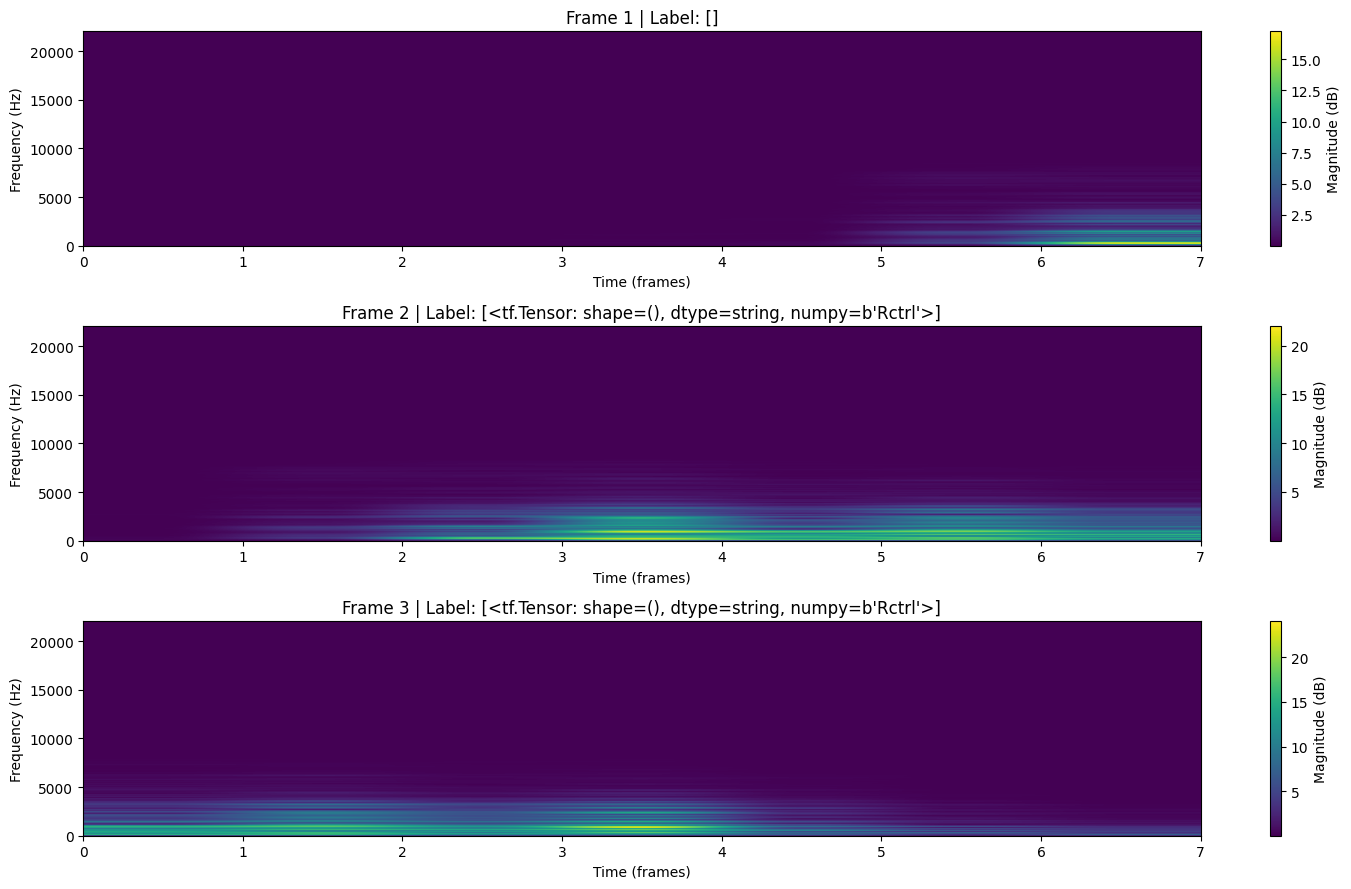

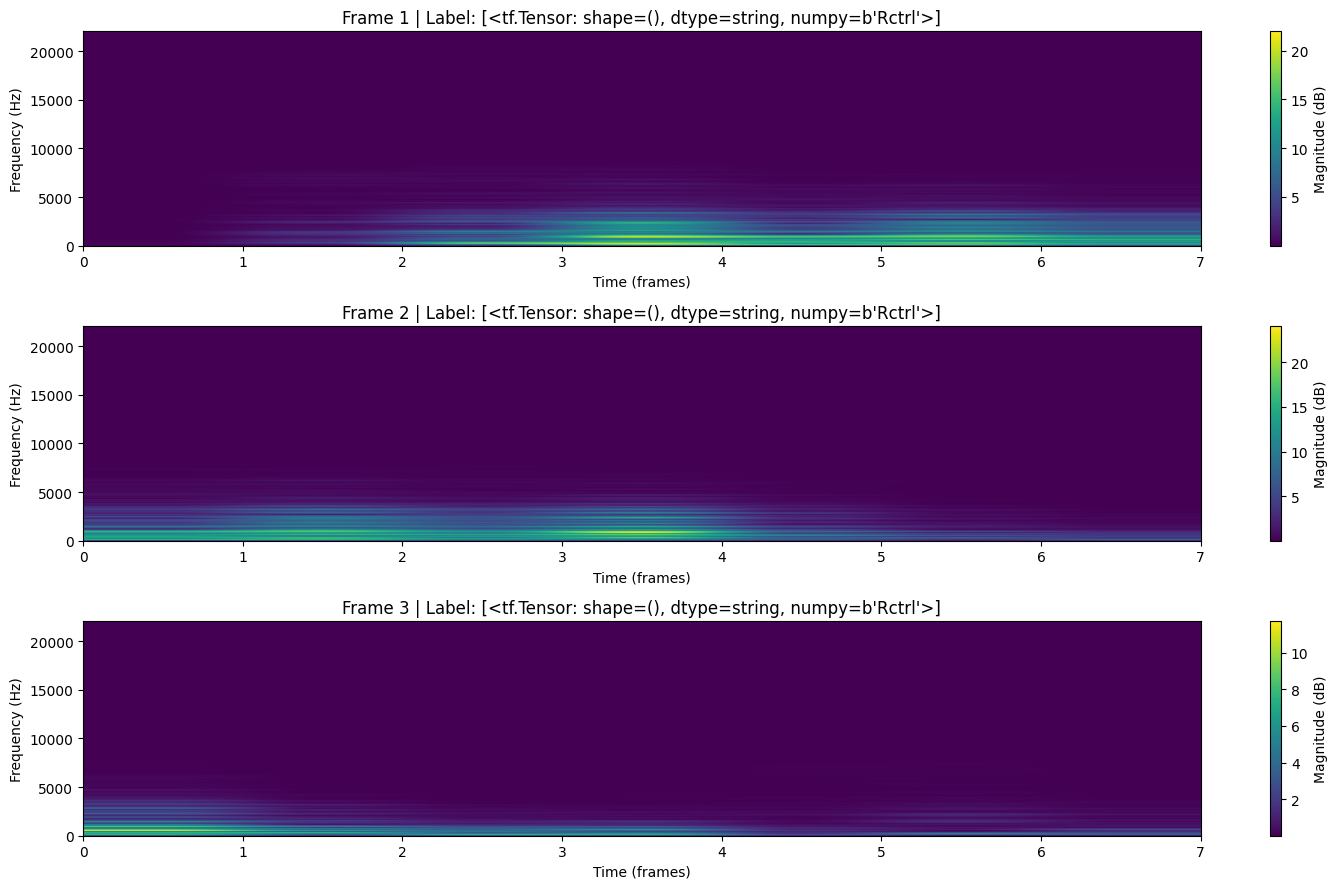

2024-12-02 17:32:35.900629: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


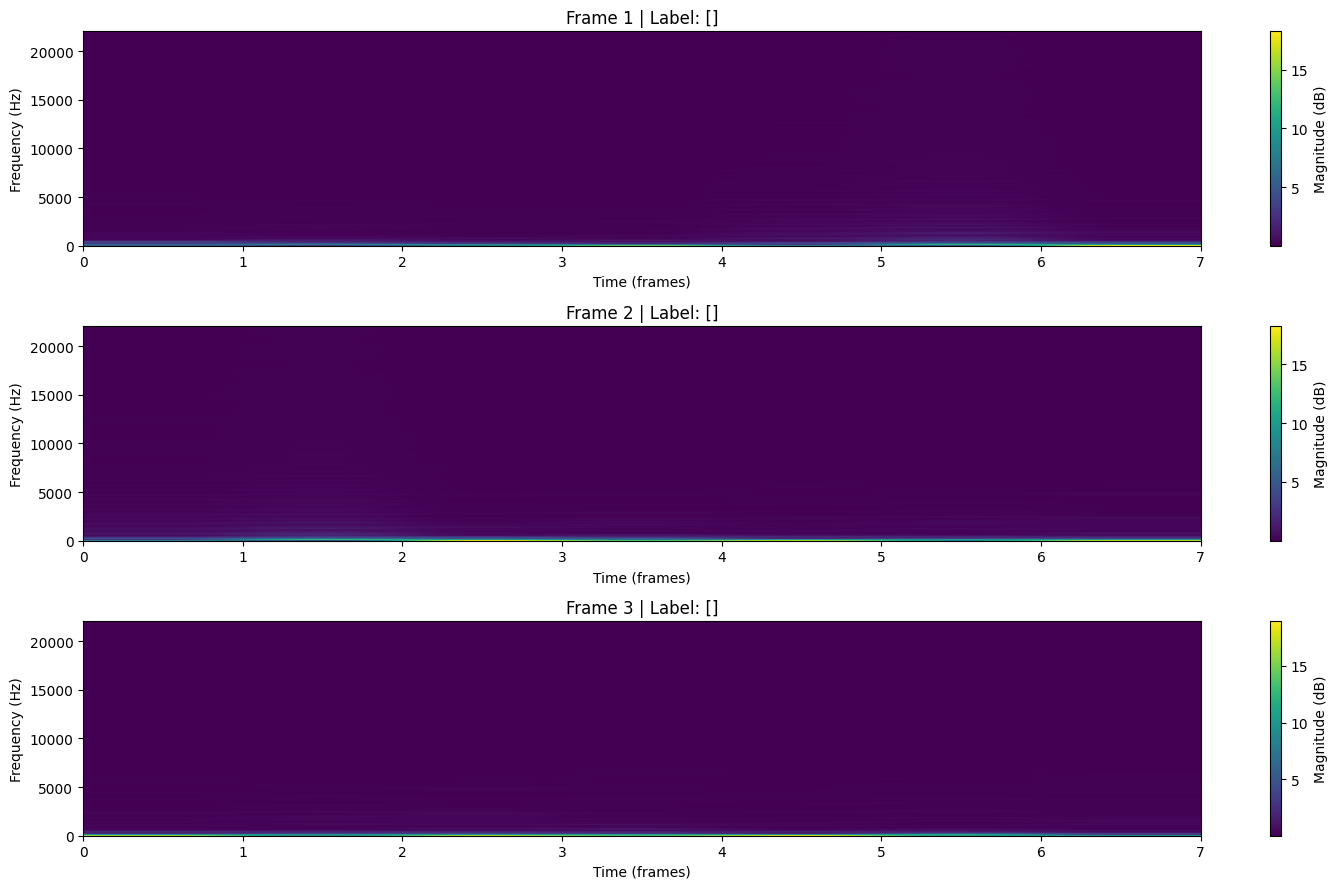

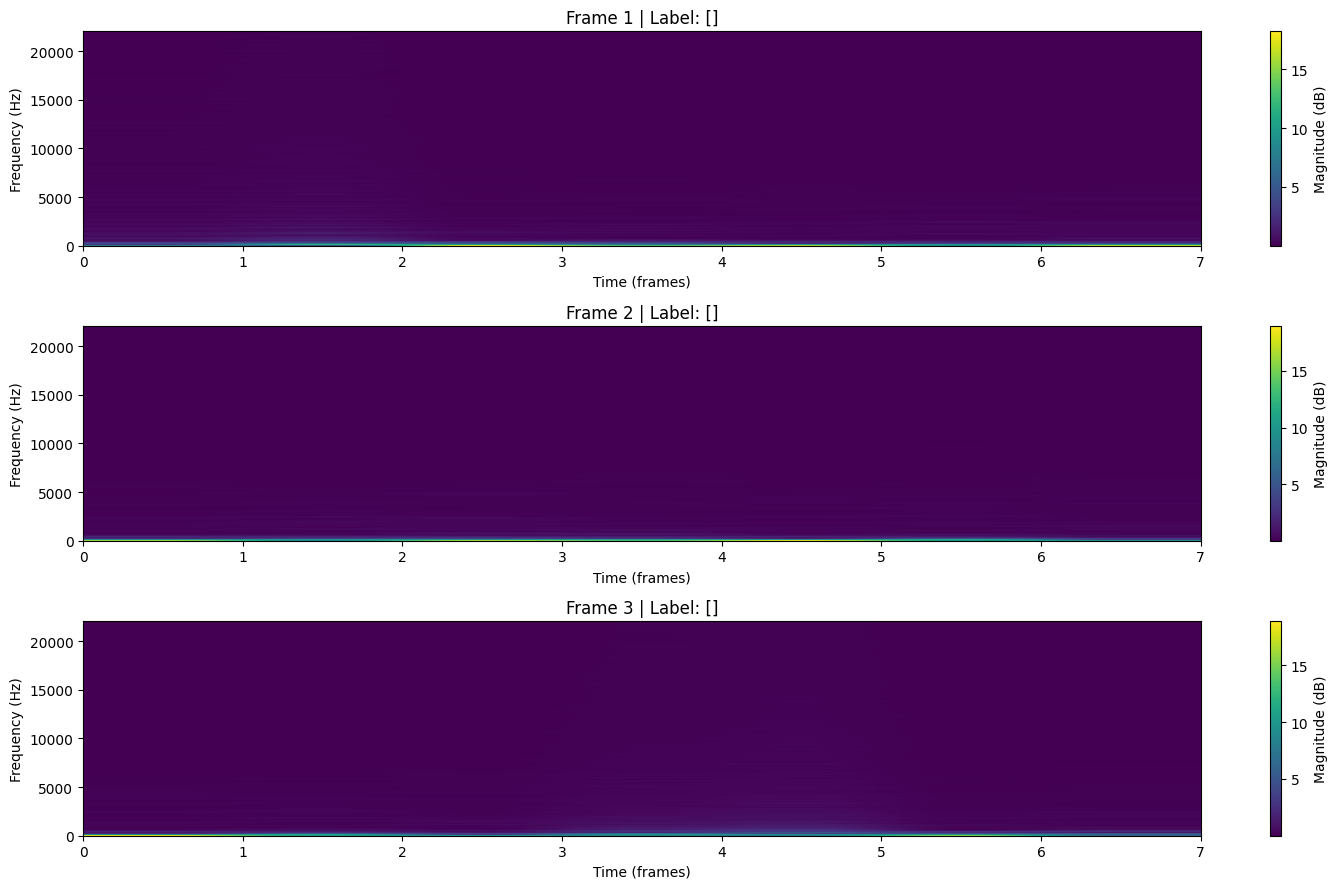

2024-12-02 17:32:37.044110: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
def plot_spectrogram_sequence(sequence, sample_rate=44100, frame_length=2205, frame_step=1102, label=None):
    sequence_length = sequence.shape[0]
    
    plt.figure(figsize=(15, 3 * sequence_length))  # Adjust figure size based on sequence length

    for i, frame in enumerate(sequence):
        # Compute STFT (Short-Time Fourier Transform)
        stft = tf.signal.stft(
            frame,
            frame_length=frame_length // 4,
            frame_step=frame_step // 4,
            fft_length=frame_length // 2,
        )
        
        # Compute magnitude spectrogram
        spectrogram = tf.abs(stft)
        spectrogram = tf.transpose(spectrogram)  # Transpose for better visualization

        # Plot the spectrogram
        plt.subplot(sequence_length, 1, i + 1)
        plt.imshow(
            10 * tf.math.log1p(spectrogram).numpy(),  # Log-scaled spectrogram
            aspect='auto',
            origin='lower',
            extent=[0, spectrogram.shape[1], 0, sample_rate / 2]
        )
        plt.colorbar(label="Magnitude (dB)")
        title = f"Frame {i + 1}"
        if label is not None:
            title += f" | Label: {label[i]}"
        plt.title(title)
        plt.ylabel("Frequency (Hz)")
        plt.xlabel("Time (frames)")

    plt.tight_layout()
    plt.show()

# ds = flattened_ds.shuffle(10000)
for sequence, label_sequence in mka_dataset.take(2):
    plot_spectrogram_sequence(sequence, label=[multi_label_binary_decode_tensor(x) for x in label_sequence])
for sequence, label_sequence in supp_dataset.take(2):
    plot_spectrogram_sequence(sequence, label=[multi_label_binary_decode_tensor(x) for x in label_sequence])



### Merge Datasets

In [5]:
# merged_dataset = mka_dataset.concatenate(supp_dataset)
merged_dataset = supp_dataset
print("Merged dataset size: ", tf.data.experimental.cardinality(merged_dataset).numpy())

Merged dataset size:  8066


## Data Augmentation

In [6]:
def add_noise(waveform, noise_level):
    noise = tf.random.normal(tf.shape(waveform), stddev=noise_level)
    return waveform + noise

def augment_volume(waveform, gain_db):
    gain = 10 ** (gain_db / 20.0)
    return waveform * gain

def augment_window(window):
    window = add_noise(window, 0.02)
    window = augment_volume(window, tf.random.uniform([], -2.0, 2.0))
    return window

def augment_sequence(sequence):
    waveforms = tf.map_fn(augment_window, sequence)
    return waveforms


augmented_dataset = merged_dataset.map(
    lambda seq, label: (augment_sequence(seq), label),
    num_parallel_calls=AUTOTUNE
)

merged_dataset = merged_dataset.concatenate(augmented_dataset)
print("Merged Dataset + Augmented Dataset Length: ", tf.data.experimental.cardinality(merged_dataset).numpy())

Merged Dataset + Augmented Dataset Length:  16132


# Spectrogram Generation

In [7]:
# Normalize waveform
def normalize_peak(waveform):
    max_amplitude = tf.reduce_max(tf.abs(waveform))
    return waveform / max_amplitude

def compute_window_spectrogram(window, frame_length=2205, frame_step=2205):

    # Perform normalization on waveform
    window = normalize_peak(window)

    spectrogram = tf.signal.stft(
        window,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length
    )

    # Compute magnitude of STFT (Spectrogram)
    spectrogram_magnitude = tf.abs(spectrogram)

    # Normalize spectrogram
    spectrogram_magnitude = tf.math.log(spectrogram_magnitude + 1e-6)  

    # print("STFT Spectrogram Shape:", spectrogram_magnitude.shape)
    return spectrogram_magnitude

def compute_sequence_spectrograms(windows, labels):
    spectrograms = tf.map_fn(compute_window_spectrogram, windows)
    
    # Remove time dimension from spectrogram since it will be the same size as the initial sliding window I have
    spectrograms = tf.squeeze(spectrograms, axis=1)
    return spectrograms, labels

spectrogram_dataset = merged_dataset.map(
    lambda windows, labels: compute_sequence_spectrograms(windows, labels),
    num_parallel_calls=AUTOTUNE
)



for spectrograms, labels in spectrogram_dataset.take(1):
    print("Spectrograms shape:", spectrograms.shape)
    print("Labels shape:", labels.shape)


Spectrograms shape: (3, 1103)
Labels shape: (3, 63)


In [8]:
def plot_sequence_spectrograms(spectrogram, title="Sample Spectrograms"):
    spectrogram = spectrogram.numpy()  # Convert TensorFlow tensor to NumPy array

    num_windows = spectrogram.shape[0]  # Number of windows (3 in this case)

    # Create a figure with subplots for each window
    fig, axes = plt.subplots(1, num_windows, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes):
        # Plot each spectrogram
        ax.imshow(
            spectrogram[i].reshape(1, -1),  # Reshape to (1, 1103) to visualize frequency bins as 1 row
            aspect="auto",
            origin="lower",
            cmap="viridis"
        )
        ax.set_title(f"Window {i+1}")
        ax.set_xlabel("Frequency Bins")
        ax.set_yticks([])  # Remove y-axis labels since there's only 1 row
        ax.set_ylabel("")  # Clear y-axis label

    plt.tight_layout()
    plt.show()

# Test plotting on the first batch
# for spectrograms, labels in spectrogram_dataset.take(1):  # Take one batch
#     for i, spectrogram in enumerate(spectrograms):  # Iterate through the batch (32 samples)
#         plot_sequence_spectrograms(
#             spectrogram, title=f"Spectrogram for Sample {i+1}"
#         )
#         if i == 2:  # Limit to first 3 samples for visualization
#             break

### Prepare Dataset for Training

In [9]:
dataset_size = sum(1 for _ in spectrogram_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

# Shuffle the dataset before splitting
shuffled_dataset = spectrogram_dataset.shuffle(buffer_size=dataset_size, reshuffle_each_iteration=False)

# Split into train val and test datasets
train_dataset = shuffled_dataset.take(train_size)
remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

# Batch and prefetch
train_dataset = train_dataset.batch(32).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=AUTOTUNE)

2024-12-02 17:32:39.697414: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Model

In [10]:
print(spectrogram_dataset.element_spec)
model = keras.Sequential([
    layers.Input(shape=(3, 1103, 1)),

    layers.TimeDistributed(layers.Conv1D(32, kernel_size=3, activation='relu')),
    layers.TimeDistributed(layers.Conv1D(128, kernel_size=3, activation='relu')),
    layers.TimeDistributed(layers.MaxPooling1D(pool_size=2)),
    layers.TimeDistributed(layers.Flatten()),  # Flatten CNN output for each window
    layers.TimeDistributed(layers.Dropout(0.3)),

    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Dense(128, activation='relu'),
    layers.Dense(63, activation="sigmoid")
])

model.summary()

(TensorSpec(shape=(3, 1103), dtype=tf.float32, name=None), TensorSpec(shape=(3, 63), dtype=tf.int32, name=None))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 3, 1101, 32)    │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 1099, 128)   │        12,416 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 549, 128)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 3, 70272)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 3, 70272)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 3, 128)         │    36,012,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3, 63)          │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,049,727 (137.52 MB)

 Trainable params: 36,049,727 (137.52 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy'] # , keras.metrics.Precision()
)

model.fit(
    train_dataset,
    epochs=20,  # Adjust as needed
    validation_data=val_dataset
)

Epoch 1/20


2024-12-02 17:32:42.888385: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1733185962.941019  766064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185962.967613  766064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185962.967937  766064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185962.970870  766064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185962.980618  766064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185962.982040  766064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185962.982324  766064 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185962.983823  766064 gpu_t

  9/404 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.0204 - loss: 0.4123

W0000 00:00:1733185963.935500  766062 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185963.936970  766062 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185963.937279  766062 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185963.937790  766062 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185963.938092  766062 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185963.938389  766062 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185963.938679  766062 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185963.938964  766062 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185963.939255  766062 gp

404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0369 - loss: 0.0767

W0000 00:00:1733185969.232464  766058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185969.232734  766058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185969.232962  766058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185969.233175  766058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185969.233404  766058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185969.233623  766058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185969.233834  766058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185969.234097  766058 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185969.234306  766058 gp

404/404 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0369 - loss: 0.0766 - val_accuracy: 0.0525 - val_loss: 0.0482
Epoch 2/20


W0000 00:00:1733185970.372828  766065 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185970.373093  766065 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185970.373318  766065 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185970.373535  766065 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185970.373767  766065 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185970.373981  766065 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185970.374208  766065 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185970.374418  766065 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733185970.374640  766065 gp

404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.0429 - loss: 0.0494 - val_accuracy: 0.0525 - val_loss: 0.0481
Epoch 3/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0461 - loss: 0.0492 - val_accuracy: 0.0525 - val_loss: 0.0477
Epoch 4/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0489 - loss: 0.0490 - val_accuracy: 0.0525 - val_loss: 0.0475
Epoch 5/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0487 - loss: 0.0489 - val_accuracy: 0.0525 - val_loss: 0.0473
Epoch 6/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0491 - loss: 0.0489 - val_accuracy: 0.0525 - val_loss: 0.0473
Epoch 7/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0498 - loss: 0.0488 - val_accuracy: 0.0525 - val_loss: 0.0473
Epoch 8/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0500 - loss: 0.0488 - val_accuracy: 0.0525 - val_loss: 0.0473
Epoch 9/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.0502 - loss: 0.0488 - val_accuracy: 0.052

## Evaluate Model

In [12]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss: {loss}, Accuracy: {accuracy}")


# predictions = model.predict(new_data)

# threshold = 0.5
# binary_predictions = (predictions > threshold).astype(int)

# # Output predictions
# print("Raw Predictions:", predictions)
# print("Binary Predictions:", binary_predictions)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0592 - loss: 0.0485
Loss: 0.04848829656839371, Accuracy: 0.058240387588739395


W0000 00:00:1733186095.755741  766061 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733186095.756024  766061 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733186095.756250  766061 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733186095.756470  766061 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733186095.756702  766061 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733186095.756910  766061 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733186095.757140  766061 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733186095.757358  766061 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733186095.757578  766061 gp

## Optimize Model